In [1]:
%run train.py --epochs 0 --dropout_branch 0.0 --use_cached True --log_path 883306


 w[data,pde,gpde,ent] = 1e+00,1e+01,1e+04,1e-02

 data path: ../data/x_K3.4_N4727_c1.0_p1e-18_t1701972209.csv
 adj path: ../data/adj_K3.4_N4727_c1.0_p1e-18_t1701972209.csv


 reading PE (LapPE, RWPE, node2vec) from file...
 Done.

MODULE: MODEL[DIMS](curv)
 encoder: HGCN[192, 96, 96](1.0)
 decoder: DeepOnet[385, 512, 512, 512, 512, 512, 3]
 pde: emergent/DeepOnet[400, 512, 512, 512, 512, 512, 1]
 pool:
   pool_0: HGCN[381, 256, 256, 32]
   pool_1: HGCN[381, 256, 256, 8]
 embed:
   embed_0: HGCN[317, 256, 256, 317]
   embed_1: HGCN[317, 256, 256, 317]
 time_enc: linlog[1]


x[train] = torch.Size([4605, 10000]), adj[train] = torch.Size([2, 36315])
x[test]  = torch.Size([122, 1, 10000]),  adj[test]  = (2, 1024)


In [118]:
def get_test_batch(model=model, num_points=10, T_max=None):
    x, adj, pe = x_test, adj_test, pe_test
    model = eqx.tree_inference(model, value=True)
    if T_max==None: T_max = T - args.tau_max - 1
    ti = jnp.linspace(args.kappa, T_max , num_points).reshape(-1,1)
    idx = ti.astype(int)
    taus = jnp.arange(1, 1+args.tau_max, 1).astype(int)
    bundles = idx + taus
    yi = x[:,bundles].T
    yi = jnp.swapaxes(yi,0,1)
    xi = _batch(x, pe, idx)
    return xi,yi,ti
    
xi,yi,ti=get_test_batch(num_points=100, T_max=None)
fwd = lambda x,t,y: model.forward(x,adj,t,y,prng(),mode='inference')
u, red, z, y, grad, S, A = jax.vmap(fwd)(xi,ti,yi)
b, u, pe, z = [z[:,:,i:j] for i,j in zip(dims[:-1],dims[1:])]

In [ ]:
L2 = jnp.square(red-y.squeeze())
idx = L2.mean(0).argsort()[::-1]

out_deg = np.array(np.unique(adj[0],return_counts=True))
in_deg = np.array(np.unique(adj[1],return_counts=True))

<Axes: >

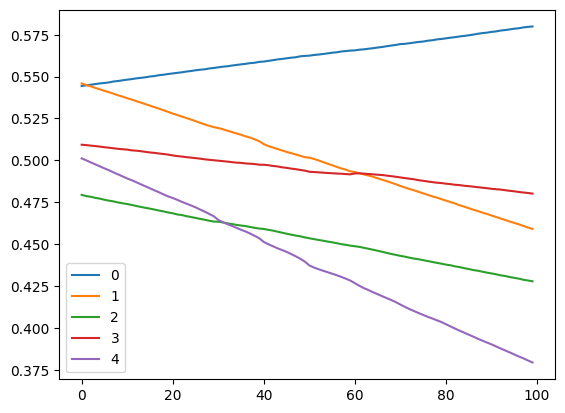

In [119]:
plot_pred = lambda i=0,j=5: pd.DataFrame(np.array(red)).iloc[:,i:j].plot()
plot_pred()

<Axes: >

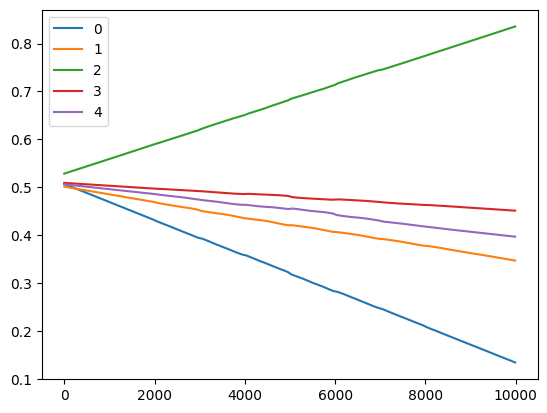

In [129]:
pd.DataFrame(x_train.numpy()).iloc[:5,::10].T.plot()